# Imports

In [82]:
import numpy as np
import rawpy
import imageio
import torch
import torchvision
import torch.nn.functional as F
from glob import glob
import matplotlib.pyplot as plt
import zipfile

In [83]:
import align

In [147]:
device = torch.device('cuda')

In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load images

In [149]:
def load_jpeg_images(image_paths):
    """loads rgb pixels from jpeg images"""
    images = []
    for path in image_paths:
        image = torchvision.io.read_image(path)
        image = image.float() / 255
        images.append(image)

    # store the pixels in a tensor
    images = torch.stack(images)
    
    print(f'burst of shape {list(images.shape)} loaded')
    return images

In [150]:
def load_raw_images(image_paths):
    """loads bayer pixels from raw images"""
    images = []
    for path in image_paths:
        with rawpy.imread(path) as raw:
            image = raw.raw_image.copy().astype(np.float32)
            images.append(image)

    # store the pixels in a tensor with an added "channel" dimension
    images = np.stack(images)
    images = torch.from_numpy(images)[:, None, :, :]

    print(f'burst of shape {list(images.shape)} loaded')
    return images

In [158]:
# image_dir = 'bursts/Jozef-RX100-12800-RAW'
# image_dir = 'bursts/Monika-RX100-51200-RAW'
image_dir = 'bursts/Monika-RX100-204800-RAW'

image_paths = sorted(glob(f'{image_dir}/*.*'))
images = load_raw_images(image_paths)

burst of shape [35, 1, 3672, 5504] loaded


# Align images

In [159]:
torch.cuda.memory_allocated()/1073741824

0.0

In [160]:
%%time
merged_image = align.align_and_merge(images, device=device)

Wall time: 8.08 s


In [161]:
torch.cuda.memory_allocated()/1073741824

0.0

# Plot reference vs. merged image

In [162]:
def get_rgb_values(image_path, bayer_array=None, **kwargs):
    """using a raw file [and modified bayer pixels], get rgb pixels"""
    # open the raw image
    with rawpy.imread(image_path) as raw:
        # overwrite the original bayer array
        if bayer_array is not None:
            raw.raw_image[:] = bayer_array
        # get postprocessed rgb pixels
        rgb = raw.postprocess(**kwargs)
    return rgb

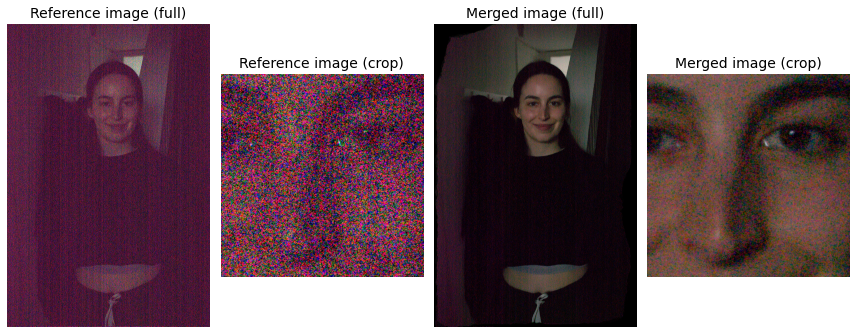

In [163]:
# convert raw images to rgb images
brigthness = 10
ref_rgb = get_rgb_values(image_paths[0], no_auto_bright=True, bright=brigthness)
merged_rgb = get_rgb_values(image_paths[0], merged_image[0], no_auto_bright=True, bright=brigthness)

# figure
font_size = 14
fig, axs = plt.subplots(1, 4, figsize=[12, 8])

# crop
crop_y = [1300, 1800]
crop_x = [1800, 2300]

# reference image
axs[0].imshow(ref_rgb)
axs[0].set_title('Reference image (full)', fontsize=font_size)
axs[1].imshow(ref_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[1].set_title('Reference image (crop)', fontsize=font_size)

# merged burst
axs[2].imshow(merged_rgb)
axs[2].set_title('Merged image (full)', fontsize=font_size)
axs[3].imshow(merged_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[3].set_title('Merged image (crop)', fontsize=font_size)

for ax in axs:
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'before_and_after.jpg', bbox_inches='tight')
plt.show()

# save processed image

In [164]:
with rawpy.imread(image_paths[0]) as raw:
    raw.raw_image[:] = merged_image[0]
    rgb = raw.postprocess(no_auto_bright=True, output_bps=16)
imageio.imsave('merged_burst.tiff', rgb)